In [1]:
import sys
sys.path += ["../src"]
import ablation_model
import causal_model
import climact_utils as cu
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import subplots as sbp
import pandas as pd
import numpy as np
from importlib import reload
from glob import glob
import matplotlib.lines as mlines

In [2]:
import dill

#### Single experiment

In [3]:
lr = 0.05
subreddit_class = "activism"
n_epochs = 10000
init_scale = 0.1
init_scale_opinions = 0.01
var_opinions = 0.01

In [4]:
with_vars = ablation_model.with_vars
with_vars

{'sociodemo_to_opinions': True,
 'activity_to_opinions': True,
 'news_to_opinions': True,
 'interaction_to_activation': True,
 'opinion_to_activation': True,
 'activity_to_activation': True,
 'news_LT_to_activation': True,
 'news_ST_to_activation': True,
 'intercept_to_activation': True}

In [2]:
complete_exp = ablation_model.full_experiment(subreddit_class, n_epochs, lr, var_opinions = var_opinions, multivariate = True, 
                                                                           date = "241002", progress_bar = False, 
                                                                           id = "abl", print_loss = True, save = False,
                                                                           return_res = True, init_scale = init_scale, 
                                                                           init_scale_opinions = init_scale_opinions, with_vars = with_vars
                                                                           )

In [ ]:
with_vars = ablation_model.with_vars
with_vars["sociodemo_to_opinions"] = False

2170
1044167.56


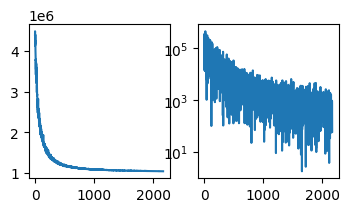

In [22]:
guide, svi_results, betas, model_settings = ablation_model.full_experiment(subreddit_class, n_epochs, lr, var_opinions = var_opinions, multivariate = True, 
                               date = "240904", progress_bar = False, 
                               id = "001", print_loss = True, save = False,
                               return_res = True, init_scale = init_scale, init_scale_opinions = init_scale_opinions, with_vars = with_vars
                               )

In [23]:
betas_no_sociodemo_to_opinion = betas

In [34]:
with_vars = ablation_model.with_vars
with_vars["activity_to_opinions"] = False

In [3]:
guide, svi_results, betas, model_settings = ablation_model.full_experiment(subreddit_class, n_epochs, lr, var_opinions = var_opinions, multivariate = True, 
                               date = "240904", progress_bar = False, 
                               id = "001", print_loss = True, save = False,
                               return_res = True, init_scale = init_scale, init_scale_opinions = init_scale_opinions, with_vars = with_vars
                               )

In [ ]:
betas_no_activity_to_opinion = betas

In [30]:
pd.DataFrame({"complete": causal_model.get_interesting_from_beta(betas_complete),
              "no_sociodemo": causal_model.get_interesting_from_beta(betas_no_sociodemo_to_opinion)})

,complete,no_sociodemo
age_to_opinion,0.0,0.0
gender_to_opinion,0.0,0.0
partisan_to_opinion,-0.33071604,0.0
affluence_to_opinion,-0.22275284,0.0
norm_climate_long_to_opinion,0.0,0.0
norm_climate_action_long_to_opinion,0.0,0.0
norm_natural_disaster_long_to_opinion,0.0,0.0
opinion_to_activation,0.8666549,0.72015506
norm_climate_long_to_activation,0.36760566,0.0
norm_climate_action_long_to_activation,-0.48275006,-0.334324


#### Experiments Analysis

In [4]:
def read_pkl(file):
    try:
        # return pd.read_pickle(file)
        with open(file, "rb") as f:
            data = dill.load(f)
        return data
    except:
        print(file)

def get_experiments_data(pickle):
    model_settings, betas,  = pickle["model_settings"], pickle["betas"]
    model_settings["loss"] = pickle["losses"][-1].item()
    model_settings["accuracy"] = pickle["model_settings"]["accuracy_mean"]
    setting_vars = ["subreddit_class", "lr", "var_opinions", "init_scale", "init_scale_opinions", "num_epochs_early_stop", "loss", "accuracy", "time", "ablation"]
    settings_s = pd.Series([model_settings[k] for k in setting_vars], index = setting_vars)
    opinions_s = betas["beta_to_opinions"][[u for u in betas["beta_to_opinions"].index if (u in cu.sociodemo_classes) or ("norm" in u)]].rename(lambda x: x + "_to_opinion")
    activation_s = betas["beta_to_activation"][:8].rename(lambda x: x + "_to_activation")
    interaction_s = betas["beta_to_interaction"][cu.sociodemo_classes].rename(lambda x: x + "_to_interaction")
    output = pd.concat([settings_s, opinions_s, activation_s, interaction_s])
    
    return output


In [4]:
for u in range(10,20):
    files = sorted(glob(causal_model.path_to_exp + f"*_abl_241009*k{u}*"))
    pickles = [causal_model.read_pkl(file) for file in files]
    df_ablation = pd.DataFrame([causal_model.get_experiments_data(pickle, other_vars_settings = ["ablation"]) for pickle in pickles])
    df_ablation.to_csv(causal_model.path_to_exp + f"activism_abl_exp_241009_k{u}.csv")
    print("save_csv", u)

save_csv 10
save_csv 11
save_csv 12
save_csv 13
save_csv 14
save_csv 15
save_csv 16
save_csv 17
save_csv 18
save_csv 19


In [17]:
# df_ablation = pd.concat([pd.read_csv(causal_model.path_to_exp + f"activism_abl_exp_241005_k{u}.csv", index_col = 0) for u in range(10, 20)])
df_ablation = pd.concat([pd.read_csv(causal_model.path_to_exp + f"activism_abl_exp_241009_k{u}.csv", index_col = 0).assign(key = u) for u in range(10, 20)])

In [13]:
# pickles = [read_pkl(file) for file in sorted(glob(causal_model.path_to_exp + "*_abl_241003*"))]
# df_ablation = pd.DataFrame([get_experiments_data(pickle) for pickle in pickles])
# print("save csv")
# df_ablation.to_csv(causal_model.path_to_exp + "activism_abl_exp_241003.csv")

In [54]:
df = df_ablation.sort_values("accuracy_mean", ascending = False).groupby(["ablation", "var_opinions"]).first().reset_index().assign(pickle = lambda x: [causal_model.path_to_exp + f"activism_abl_241009_abl_{ablation}_v{str(var_opinions)}_k{key}.pkl" for ablation, var_opinions, key in zip(x["ablation"], x["var_opinions"], x["key"])])

In [6]:
# selected_var_opinion = ["1e-09", "0.001", "0.01", "0.1", "1.0", "10.0", "100.0", "1000.0", "10000000.0"]
selected_var_opinion = ["0.01", "1.0", "100.0"]
# selected_var_opinion = ["0.001", "0.1", "10.0", "1000.0"]
selected_var_opinion = [float(u) for u in selected_var_opinion]

marker = ['o', 'x', '^', '+', '*', '8', 's', 'p', 'D', 'V']
marker_plot = ['o', 'x', '^', 's', 'D']

mypalette = sns.color_palette("colorblind")
mypalette = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.9, reverse=False, as_cmap=False)[1:(1 + len(selected_var_opinion))]
mypalette = mypalette = [sns.color_palette("YlGn", n_colors = 20)[u] for u in [6,11,16]]

n_ablations = len(df["ablation"].unique())

/tmp/ipykernel_3399976/2585877521.py:5: UserWarning: 
The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sp = sns.stripplot(


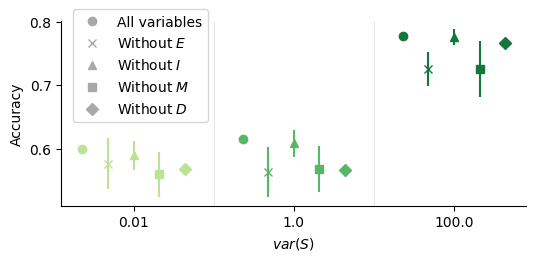

In [8]:
fig, axes = sbp(figsize = (6, 2.4))

condition = "var_opinions in @selected_var_opinion"

sp = sns.stripplot(
    data = df.query(condition), x = "var_opinions", y = "accuracy_mean", hue = "ablation", palette = mypalette,
    alpha = 0.,
    dodge = True,
    jitter = False,
)


xy_coordinates = np.concatenate([u.get_offsets().data for u in sp.collections]) 
# cols = [u.get_facecolor()[0][:3] for u in sp.collections]
# cols = mypalette
cols = np.repeat(mypalette, n_ablations, axis=0)
axes.axvline(x = 0.5, c = "grey", alpha = 0.3, linewidth = 0.5)
axes.axvline(x = 1.5, c = "grey", alpha = 0.3, linewidth = 0.5)

axes.yaxis.grid(False)
axes.xaxis.grid(False)

for i in range(len(df.query(condition))):
  x, y = xy_coordinates[i]
  col = cols[i]
  # col = cols[i % n_ablations]
  axes.errorbar(x = x, y = y, 
                yerr = df.query(condition).sort_values(["var_opinions", "ablation"])["accuracy_std"].iloc[i], 
                marker = marker_plot[i % n_ablations],
                c = col)


axes.set_ylabel("")
axes.set_xlabel("")

axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

# axes.set_title("$\\beta_{SYM}$")
# axes.set_yticklabels([str(u).replace("_to_opinion", "") for u in df["index"].unique()])

# handles, _ = plt.gca().get_legend_handles_labels()
remove_str = "Without"
labels = ["All variables", remove_str +  " $E$", remove_str +  " $I$", remove_str +  " $M$", remove_str +  " $D$"]

handles = [mlines.Line2D([], [], color = "darkgrey", marker = marker_plot[u], linestyle='None',
                          label = label) for u, label in enumerate(labels)]

axes.legend(handles = handles, title = "", loc = "upper right", bbox_to_anchor=(0.33, 1.1))
axes.set_ylabel("Accuracy")
axes.set_xlabel("$var(S)$")

axes.set_yticks([0.6, 0.7, 0.8])

fig.show()
fig.savefig(f"../paper/ablation_errorplot.pdf", format = "pdf", bbox_inches = "tight")


#### CI sociodemo_to_interaction

In [ ]:
pickles = {s: causal_model.read_pkl(s) for s in df["pickle"]}

In [ ]:
from numpyro import distributions
from causal_model import PRNGKey
interesting_coefs_loc_names = ["beta_sociodemo_to_opinions_loc", "beta_news_to_opinions_loc", 
                               "beta_sociodemo_to_interaction_auto_loc", 
                              #  "beta_sociodemo_to_interaction_loc", 
                               "beta_opinion_to_activation_auto_loc", 
                               "beta_interaction_to_activation_auto_loc", 
                               "beta_news_LT_to_activation_loc", 
                               "beta_news_ST_to_activation_loc", 
                               "beta_sociodemo_to_sub_ST_loc",
                               "beta_retention_to_sub_ST_auto_loc"]
coefs_index = ["age_to_opinion", "gender_to_opinion", "partisan_to_opinion",  "affluence_to_opinion", 
               "climate_LT_to_opinion", "climate_action_LT_to_opinion", "natural_disaster_LT_to_opinion", 
               "age_to_interaction", "gender_to_interaction", "partisan_to_interaction",  "affluence_to_interaction", 
               "opinion_to_activation", "interaction_to_activation", "climate_LT_to_activation", "climate_action_LT_to_activation", "natural_disaster_LT_to_activation",
                "climate_ST_to_activation", "climate_action_ST_to_activation", "natural_disaster_ST_to_activation",
                "age_to_sub_ST", "gender_to_sub_ST", "partisan_to_sub_ST",  "affluence_to_sub_ST", "retention_to_sub_ST"]
interesting_coefs_scale_names = [u.replace("auto_loc", "auto_scale").replace("_loc", "_scale_tril") for u in interesting_coefs_loc_names]

In [ ]:
def return_percentiles(params_dict, key, coefs_loc_name, coefs_scale_name,  perc1 = 5, perc2 = 95):
    if "tril" in coefs_scale_name:
        samples = distributions.MultivariateNormal(params_dict[key][coefs_loc_name], params_dict[key][coefs_scale_name]).sample(PRNGKey(10), (10000,))
    else:
        samples = distributions.Normal(params_dict[key][coefs_loc_name], params_dict[key][coefs_scale_name]).sample(PRNGKey(10), (10000,))
    return np.percentile(samples, perc1, axis = 0), np.percentile(samples, perc2, axis = 0)

def get_df_mean_ci(params_dict, key, perc1 = 5, perc2 = 95, coefs_loc_names = interesting_coefs_loc_names, coefs_scale_names = interesting_coefs_scale_names, coefs_index = coefs_index):
    all_perc_one_exp = [return_percentiles(params_dict, key, coefs_loc_names[u], coefs_scale_names[u], perc1 = perc1, perc2 = perc2) for u in range(len(coefs_loc_names))]
    df = pd.DataFrame([np.concatenate([np.array(params_dict[key][u]) for u in coefs_loc_names]), (np.concatenate([u[0] for u in all_perc_one_exp])), (np.concatenate([u[1] for u in all_perc_one_exp]))], 
                              index = ["mean", "lower", "upper"], columns = coefs_index).T[-1::-1]
    return df

def rgb_to_hex(rgb):
    return '#' + ''.join(f'{int(c * 255):02x}' for c in rgb)

In [101]:
coefs_mean_ci_ablation = {s: get_df_mean_ci(params_dict = {0: pickles[s]["params"]}, key = 0, coefs_loc_names = ["beta_sociodemo_to_interaction_auto_loc"],  coefs_scale_names = ["beta_sociodemo_to_interaction_auto_scale"], coefs_index = ["age", "gender", "partisan",  "affluence"]).assign(ablation = s.split("_")[-3], var_opinions = s.split("_")[-2][1:]) for s in pickles}

In [102]:
df_ci_ablation = pd.concat(coefs_mean_ci_ablation).reset_index().drop(columns = ["level_0"]).rename(columns = {"level_1": "sociodemo"}).assign(error = lambda x: x["mean"] - x["lower"])

In [103]:
df_ci_ablation.head()

,sociodemo,mean,lower,upper,ablation,var_opinions,error
0,affluence,-0.385912,-0.457691,-0.314254,complete,1e-09,0.071779
1,partisan,-0.989942,-1.173425,-0.809790,complete,1e-09,0.183483
2,gender,-0.320389,-0.485369,-0.163591,complete,1e-09,0.164980
3,age,0.409874,0.301895,0.520609,complete,1e-09,0.107979
4,affluence,-0.387835,-0.480654,-0.295173,complete,0.001,0.092819


/tmp/ipykernel_3483925/137984898.py:8: UserWarning: 
The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sp = sns.stripplot(
/tmp/ipykernel_3483925/137984898.py:8: UserWarning: 
The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sp = sns.stripplot(


/tmp/ipykernel_3483925/137984898.py:8: UserWarning: 
The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sp = sns.stripplot(
/tmp/ipykernel_3483925/137984898.py:8: UserWarning: 
The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sp = sns.stripplot(


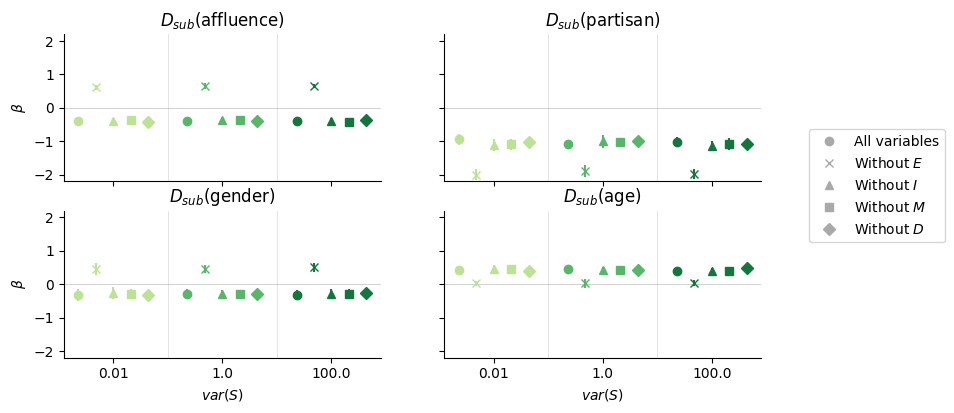

In [146]:
fig, axes = sbp(ncols = 2, nrows = 2, figsize = (9, 4.2), sharex = True, sharey = True)

for k, sociodemo in enumerate(["affluence", "partisan", "gender", "age"]):
  i,j = int(np.floor(k / 2)), k % 2
  
  condition = f"(var_opinions in @selected_var_opinion)&(sociodemo == '{sociodemo}')"

  sp = sns.stripplot(
      data = df_ci_ablation.query(condition), x = "var_opinions", 
      y = "mean", hue = "ablation", palette = mypalette,
      alpha = 0.,
      dodge = True,
      jitter = False,
      ax = axes[i,j]
  )


  xy_coordinates = np.concatenate([u.get_offsets().data for u in sp.collections]) 
  # cols = [u.get_facecolor()[0][:3] for u in sp.collections]
  # cols = mypalette
  cols = np.repeat(mypalette, n_ablations, axis=0)
  axes[i,j].axvline(x = 0.5, c = "grey", alpha = 0.3, linewidth = 0.5)
  axes[i,j].axvline(x = 1.5, c = "grey", alpha = 0.3, linewidth = 0.5)

  axes[i,j].axhline(y = 0, c = "grey", alpha = 0.5, linewidth = 0.5)

  axes[i,j].yaxis.grid(False)
  axes[i,j].xaxis.grid(False)

  for h in range(len(df_ci_ablation.query(condition))):
    x, y = xy_coordinates[h]
    col = cols[h]
    # col = cols[i % n_ablations]
    axes[i,j].errorbar(x = x, y = y, 
                  yerr = df_ci_ablation.query(condition).sort_values(["var_opinions", "ablation"])["error"].iloc[h],
                  marker = marker_plot[h % n_ablations],
                  c = col)


  axes[i,j].set_ylabel("")
  axes[i,j].set_xlabel("")

  axes[i,j].set_ylim(-2.2,2.2)

  axes[i,j].spines['top'].set_visible(False)
  axes[i,j].spines['right'].set_visible(False)

  # axes.set_title("$\\beta_{SYM}$")
  # axes.set_yticklabels([str(u).replace("_to_opinion", "") for u in df["index"].unique()])

  # handles, _ = plt.gca().get_legend_handles_labels()
  remove_str = "Without"
  labels = ["All variables", remove_str +  " $E$", remove_str +  " $I$", remove_str +  " $M$", remove_str +  " $D$"]

  handles = [mlines.Line2D([], [], color = "darkgrey", marker = marker_plot[u], linestyle='None',
                            label = label) for u, label in enumerate(labels)]

  axes[i,j].legend(handles = handles, title = "", loc = "upper right", bbox_to_anchor=(2.8, 0.4)).set_visible(k == 0)
  axes[i,j].set_title("$D_{sub}$" + f"({sociodemo})")
  
  axes[i,j].set_xlabel("$var(S)$")
  axes[i,j].set_ylabel("$\\beta$")

  # axes.set_yticks([0.6, 0.7, 0.8])

  fig.show()
  # fig.savefig(f"../paper/ablation_errorplot.pdf", format = "pdf", bbox_inches = "tight")
